In [1]:
# Author: Volker Hoffmann, SINTEF <volker.hoffmann@sintef.no> <volker@cheleb.net>
# Update: 26 November 2018

In this notebook, we demonstrate how to

1. Load some data from an sensor, and
2. How to get some descriptive, visual, and predictive analytics

As an example, we use an air temperature sensor which was placed around in our offices for a while. One fine day, somebody decided to move it.

The first three cells are generic Python preamble. They load different libraries (called modules in Python) and set up our environment.

A big part of working in Python is knowing the right libraries to get stuff done. In this notebook, we use

- `Pandas` to handle our data
- `Matplotlib` and `Seaborn` to make figure
- `Scikit-learn` to compute clusters

Other helpers are

- `Glob` to get a list of files according to some pattern 
- `Bumpy` to do some computations
- `Warnings` to modify the verbosity of warnings

In [2]:
%matplotlib inline

In [3]:
import matplotlib as mpl; mpl.rcParams['figure.dpi'] = 96
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

The next few cells demonstrate how to load files into Pandas.

When we're done, we will have the data loaded into a structure called a Dataframe.

The core function to load data from a CSV file is `pd.read_csv()`.

You can think of it as an in-memory Excel table that you can use (to do machine learning, etc) and modify (calculate new columns, averages, etc) using Python.

The dataframe will be accessible as the variable `df`.

The final two cells are housekeeping tasks for convenience. We rename the `value` column (the name `value` was picked up from the CSV file header) and make sure the `timestamp` has the correct Pandas datatype (which allows advance time based operations).

In [5]:
# NB: Do this if the data is somewhere else
# datadir = '/home/volkerh/Notebooks/biglearn_course'
# g = glob.glob("%s/*.csv" % datadir)

In [6]:
g = glob.glob("*DigiFab*.csv")

In [7]:
print(g)

['TempAir-DigiFab_20006414_2018-10-01 00_00_00_2018-11-30 23_59_59.csv']


In [8]:
df = pd.read_csv(g[0])

In [9]:
df.rename(columns={'value': 'air_temperature'}, inplace=True)

In [10]:
df['timestamp'] = pd.to_datetime(df.timestamp)

# Inspect Data / Descriptive Analytics

Before we do anything, let us have a look at what we have in our dataframe.

- The command `df.head(5)` show the first five rows of the dataframe.
- The command `df.info()` shows general information (how many rows of data, what columns, what datatypes, etc)
- The command `df.describe()` computes and shows basic descriptive statistics (percentiles, averages, and counts) for each column

In [11]:
df.head(5)

,timestamp,air_temperature,rssi
0,2018-10-01 00:00:31,21.9,-80
1,2018-10-01 00:04:33,21.9,-80
2,2018-10-01 00:08:36,21.9,-80
3,2018-10-01 00:12:38,21.9,-80
4,2018-10-01 00:14:39,21.9,-80


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34378 entries, 0 to 34377
Data columns (total 3 columns):
timestamp          34378 non-null datetime64[ns]
air_temperature    34378 non-null float64
rssi               34378 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 805.8 KB


In [13]:
df.describe()

,air_temperature,rssi
count,34378.000000,34378.000000
mean,13.702132,-68.407354
std,10.166517,13.648599
min,-3.800000,-134.000000
25%,2.200000,-81.000000
50%,21.300000,-71.000000
75%,22.300000,-56.000000
max,25.500000,-25.000000


# Visual Analytics

Let's make some figures so we can actually see what the dat looks like.

First, we just look at the time series (over two months).

The `pass` instruction at the bottom of the cells supresses some annoying text output.

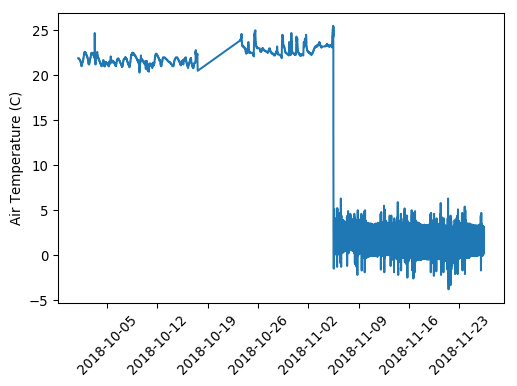

In [14]:
plt.plot(df.timestamp, df.air_temperature)
plt.xticks(rotation=45)
# plt.xlabel('Time')
plt.ylabel('Air Temperature (C)')
pass

Interesting, it seems something has happened to our sensor around **15 October** and **02 November**. Let's get back to the that.

For now, a nice way of summarizing what a time series of measurements does is to plot the distribution of measurements. In other words, we ignore the time dependence and just have a look what kind of measurement values we observe.

We first make this plot for the air temperature.

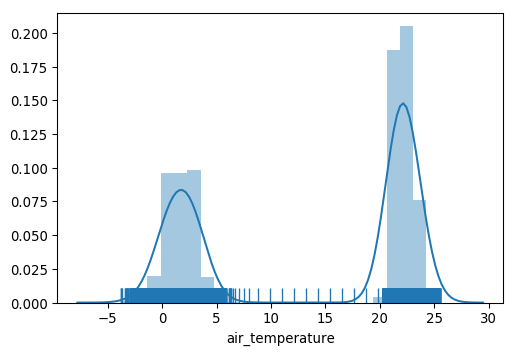

In [15]:
sns.distplot(df.air_temperature, rug=True)
pass

Ok, now we know that most measurements of air temperature either happen around **2C** or **22C**. Curious.

Recall that we also found a column called "RSSI", which is an indicator of the signal strength from the sensor to the base station.

Let us have a look at this.

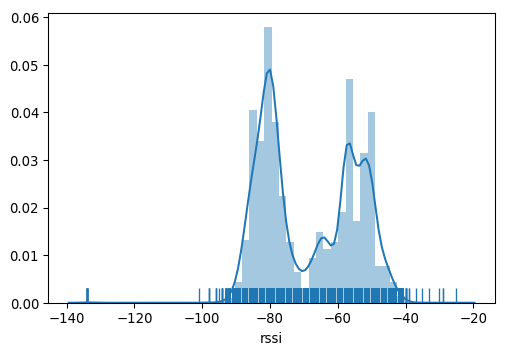

In [16]:
sns.distplot(df.rssi, rug=True)
pass

Again, it appears as though there are two distinct operating regimes for our sensor -- one with lower and one with higher signal strength levels.

So, we have variations in temperature and signal strength. Maybe somebody moved our sensors around?

Let's have a look at how the measurements of signal strength and observed air temperature relate.

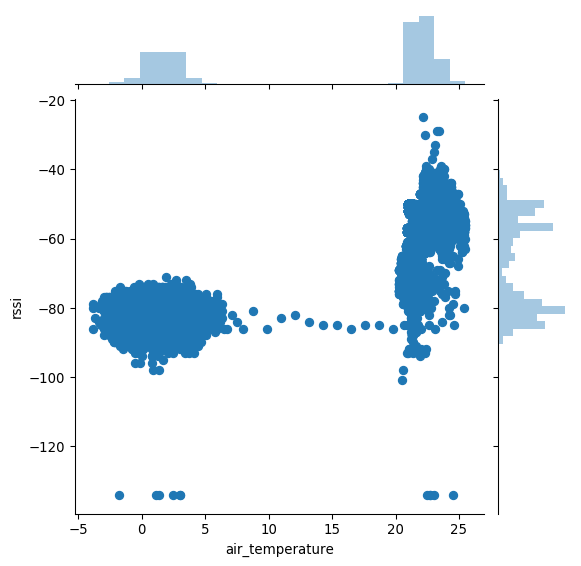

In [17]:
# sns.jointplot(df.value, df.rssi, joint_kws={'s': 36, 'facecolor': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'edgecolor': 'white'}, lw=0.5)
sns.jointplot(df.air_temperature, df.rssi)
pass

On top and on the right, we see the individual histograms we have seen for the signal strength and air temperature before.

The big panel in the middle is a **scatterplot** of all individual measurements. We clearly see that, at air temperatures $<5C$, signal strength never exceeds $-70$.

At higher temperatures, signal strength can reach all the way up to $-20$.

Curious, maybe somebody moved the sensor into the fridge?

![title](Digifab.jpg)

# Clustering

Humans have an outstanding visual processing capacity in their brains. Unfortuntaly, in the real world, we cannot have humans look at data streams from hundreds of sensors.

So we would like to automated the procedure of finding clusters of different operating conditions for our sensors.

This is called clustering.

We now try an algorithm called DBSCAN that will attempt to find the two major clusters we have so easily found in the image above.

In [18]:
import sklearn.cluster

In [19]:
db = sklearn.cluster.DBSCAN(eps=1.5)

In [20]:
db.fit(df[['air_temperature','rssi']])

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [21]:
# Don't worry about this bit, we're just making sure we have nice colours when we make the figure below
labels = db.labels_
labels = list(labels)
new_labels = []
for label in labels:
    if label == 0:
        new_labels.append(sns.color_palette()[0])
    elif label == 1:
        new_labels.append(sns.color_palette()[1])
    elif label == 2:
        new_labels.append(sns.color_palette()[2])
    elif label == 3:
        new_labels.append(sns.color_palette()[3])

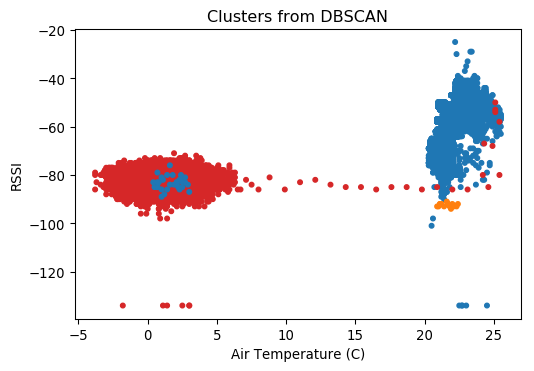

In [22]:
# plt.scatter(df.value, df.rssi, c=db.labels_)
plt.scatter(df.air_temperature, df.rssi, c=new_labels, s=12)
plt.title('Clusters from DBSCAN')
plt.xlabel('Air Temperature (C)')
plt.ylabel('RSSI')
pass

Ok, this is same figure as above with two exceptions:

1. We have removed the histograms on the side
2. We have coloured each point according to the cluster the **ALGORITHM THINKS** the point is in

We clearly see that the algorithm has managed to lump most points into the correct clusters. But not all!

This, unfortunately, the reality of applying machine learning in practice. During the first experiments, things usually don't go very smoothly and it takes experience (and persistence) to

1. Select the most suitabel algorithms.
2. Adjust it properly.

This needs to be done with domain experts who know very well the proper operating regimes of their machines.

# Automated Anomaly Detection

The fact that somebody ran off with our sensor and placed it into the fridge is obviously something we wish we could detect automatically.

The sudden drop in temperature (and signal strength) is an **anomaly**, which a suitable algorithm can detect automatically.

Again, for a few sensors, it is absolutely feasible to have human operators monitor the sensor streams. For thousands of streams, this is not feasible.

The simplest way to detect anomalies is to calculate a rolling mean $\mu$ along with the $\sigma$ and check whether new observations are within this band of expectation.

So let's calculate these rolling measures and make a mark if we find new values that are $>3\sigma$ away from the mean.

In [23]:
df['mavg'] = df['air_temperature'].rolling(2048).mean()
df['mstd'] = df['air_temperature'].rolling(2048).std()

This is what (a short slice) of our dataframe now looks like. Note the new columns `mavg` and `mstd`.

In [24]:
df.tail(5)

,timestamp,air_temperature,rssi,mavg,mstd
34373,2018-11-26 10:09:54,2.5,-83,1.697119,1.183891
34374,2018-11-26 10:11:59,2.7,-83,1.696289,1.182591
34375,2018-11-26 10:14:04,2.4,-80,1.695166,1.180828
34376,2018-11-26 10:16:09,2.1,-83,1.693896,1.178992
34377,2018-11-26 10:18:15,2.3,-86,1.693018,1.177867


Now we can extract rows where the measurement is $>3 \sigma$ away from the rolling mean.

Below, we also plot the time series of observations and mark the instances where we have detected an anomaly.

In [25]:
outliers = df[(df.air_temperature > (df.mavg + 3.0 * df.mstd)) | \
              (df.air_temperature < (df.mavg - 3.0 * df.mstd))]

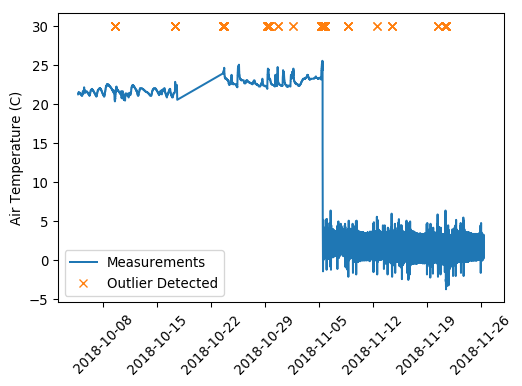

In [26]:
plt.plot(df.timestamp[2048:], df.air_temperature[2048:], label='Measurements')
plt.plot(outliers.timestamp, np.ones(outliers.shape[0]) * 30.0, 'x', label='Outlier Detected')
plt.xticks(rotation=45)
plt.ylabel('Air Temperature (C)')
plt.legend(loc='lower left')
pass

In [27]:
# How to make this better?
# 1/ fit an (S)AR(I)MA(X) model, then look at outliers
# 2/ fit an SVM and look whether stuff is outside
# 3/ ...